In [1]:
import numpy as np
# import pandas as pd
from xclib.data import data_utils
import matplotlib.pylab as plt
from random import seed
from random import randrange
import math
import time
import numexpr as ne
from multiprocessing import Pool
from joblib import Parallel, delayed
from collections import deque

In [2]:
# paths
data_folder_path = './data/'
train_x_path = data_folder_path + 'train_x.txt'
train_y_path = data_folder_path + 'train_y.txt'
train_size = (64713, 482)
test_x_path = data_folder_path + 'test_x.txt'
test_y_path = data_folder_path + 'test_y.txt'
test_size = (21571, 482)
val_x_path = data_folder_path + 'valid_x.txt'
val_y_path = data_folder_path + 'valid_y.txt'
val_size = (21572, 482)

In [3]:
def load_y(path, size):
    y = np.ones(size)
    f = open(path)
    cnt = 0
    for x in f:
        y[cnt] = int(x)
        cnt += 1
    return y

In [2]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.index = 1
        self.depth = 0


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y, 1)


    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _entropy(self, X, y):
        m = y.size
        n = X.shape[0]
        a2 = np.count_nonzero(y==1)
        a1 = m - a2
        
        # print('ggg', a1, a2)
        if(a1==0):
            return 0
        elif(a2==0):
            return 1
        return (-1 * (a1/y.shape[0]) * math.log2((a1/y.shape[0])) + (-1 * (a2/y.shape[0]) * math.log2((a2/y.shape[0]))))

            # return 0.5
    def _tovectoriz(self, X, y, idx, entropy_class):
        # print(idx)
        median = np.median(X[:, idx])
        
        data_left = np.array([np.array([i, clas]) for i,clas in zip(X[:, idx],y) if i<=median])
        if(data_left.size==0):
            entropy_left = 0
            size0 = 0
        else:
            entropy_left = self._entropy(data_left[:,0], data_left[:,1])
            size0 = data_left[:,1].shape[0]

        
        data_right = np.array([np.array([i, clas]) for i,clas in zip(X[:, idx],y) if i>median])
        if(data_right.size==0):
            entropy_right = 0
            size1 = 0
        else:
            entropy_right = self._entropy(data_right[:,0], data_right[:,1])
            size1 = data_right[:,1].shape[0]
        
        temp = size0/(size0+size1)
        varr = (temp * entropy_left + (1-temp) * entropy_right)
        return varr

    # Return best attribute for splitting data with its corresponding threshold to split.
    def _best_split(self, X, y):
        m = y.size
        n = X.shape[1]
        if m<=1:
            return None, None
        
        best_idx, best_thr = None, None
        entropy_class = self._entropy(X, y)
        
        entropy_attr = [(entropy_class - self._tovectoriz(X, y, i, entropy_class)) for i in range(n)]
        
        # entropy_attr = [0] * n
        # for i in range(n):
        #     remp = self._tovectoriz(X, y, i, entropy_class)
        #     # if(remp>entropy_class):
        #     #     print(remp, entropy_class)
        #     #     return None, None
        #     entropy_attr[i] = entropy_class - self._tovectoriz(X, y, i, entropy_class)

        # entropy_attr = [0] * (n)
        # entropy_attr = Parallel(n_jobs=-1, verbose=0, backend="threading")(map(delayed(self._tovectoriz), X, y, i, entropy_class))

        # print(entropy_attr)
        # if(np.count_nonzero(np.array(entropy_attr)==0)==len(entropy_attr)):
        #     return None, None
        best_idx = np.argmax(entropy_attr)
        best_thr = np.median(X[:,best_idx])
        if(entropy_attr[best_idx]>=entropy_class):
            return None, None
        
        return best_idx, best_thr

#     def _best_split_old(self, X, y):
#         m = y.size
#         if m <= 1:
#             return None, None
#         num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
#         best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
#         best_idx, best_thr = None, None
#         for idx in range(self.n_features_):
#             thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
#             num_left = [0] * self.n_classes_
#             num_right = num_parent.copy()
#             for i in range(1, m):
#                 c = int(classes[i - 1])
#                 num_left[c] += 1
#                 num_right[c] -= 1
#                 gini_left = 1.0 - sum(
#                     (num_left[x] / i) ** 2 for x in range(self.n_classes_)
#                 )
#                 gini_right = 1.0 - sum(
#                     (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
#                 )
#                 gini = (i * gini_left + (m - i) * gini_right) / m
#                 if thresholds[i] == thresholds[i - 1]:
#                     continue
#                 if gini < best_gini:
#                     best_gini = gini
#                     best_idx = idx
#                     best_thr = (thresholds[i] + thresholds[i - 1]) / 2
#                 # print(best_idx, best_thr)
#         # print(best_idx, best_thr)
#         return best_idx, best_thr

    # Return best attribute for splitting data with its corresponding threshold to split.
#     def _best_split(self, X, y):
#         m = y.size
#         if m <= 10:
#             return None, None
#         num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
#         try:
#             best_entropy = -1.0 * sum((n / m) * (math.log2((n / m))) for n in num_parent)
#         except:
#             best_entropy = 0
#         best_idx, best_thr = None, None
#         for idx in range(self.n_features_):
#             thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
#             num_left = [0] * self.n_classes_
#             num_right = num_parent.copy()
#             for i in range(1, m):
#                 c = int(classes[i - 1])
#                 num_left[c] += 1
#                 num_right[c] -= 1
#                 try:
#                     entropy_left = -1.0 * sum((num_left[x] / i) * (math.log2((num_left[x] / i))) for x in range(self.n_classes_))
#                 except:
#                     entropy_left = 0
#                 try:
#                     entropy_right = -1.0 * sum((num_right[x] / (m - i)) * (math.log2((num_right[x] / (m - i)))) for x in range(self.n_classes_))
#                 except:
#                     entropy_right = 0
#                 entropy = (i * entropy_left + (m - i) * entropy_right) / m
#                 if thresholds[i] == thresholds[i - 1]:
#                     continue
#                 if entropy < best_entropy:
#                     best_entropy = entropy
#                     best_idx = idx
#                     best_thr = (thresholds[i] + thresholds[i - 1]) / 2
#                 # print(best_idx, best_thr)
#         # print(best_idx, best_thr)
#         return best_idx, best_thr

    def _grow_tree(self, X, y, index, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        node.index = index
#         print(depth)
        idx = -1
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X[X[:,idx]<=thr],  y[X[:, idx]<=thr], node.index*2, depth + 1)
                node.left.depth = depth + 1
                node.right = self._grow_tree(X[X[:, idx]>thr], y[X[:, idx]>thr], node.index*2+1, depth + 1)
                node.right.depth = depth + 1

        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [5]:
def get_accuracy(clf, a, b):
    i = 0
    cnt = 0
    for x in clf.predict(a):
        if(x==b[i]):
            cnt += 1
        i+=1
    return (cnt/i)

In [6]:
# FUNCTION CALLING STARTS
# DATA LOADING...
train_x = data_utils.read_sparse_file(train_x_path)
train_y = load_y(train_y_path, train_x.shape[0])

test_x = data_utils.read_sparse_file(test_x_path)
test_y = load_y(test_y_path, test_x.shape[0])

val_x = data_utils.read_sparse_file(val_x_path)
val_y = load_y(val_y_path, val_x.shape[0])

i = 0
train_data = np.zeros(shape=train_size)
for x in train_x.toarray():
    train_data[i] = [int(i) for i in x]
    i += 1
# train_data = train_data[:100, :]
# train_y = train_y[:100]

i = 0
test_data = np.zeros(shape=test_size)
for x in test_x.toarray():
    test_data[i] = [int(i) for i in x]
    i += 1
# test_data = test_data[:100, :]
# test_y = test_y[:100]

i = 0
val_data = np.zeros(shape=val_size)
for x in val_x.toarray():
    val_data[i] = [int(i) for i in x]
    i += 1
# val_data = val_data[:100, :]
# val_y = val_y[:100]

/home/karan/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [7]:
X, y = train_data, train_y

In [9]:
# DEFINE CLASSIFIER
clf = DecisionTreeClassifier(max_depth=40)
start = time.time()
clf.fit(X, y)
print('Training Time: ', (time.time()-start)/60)

Training Time:  57.10534771680832


In [12]:
q = deque()
q.append(clf.tree_)

ll = []
cnt = 0
while(q):
    temp = q.popleft()
    if(temp is None):
        continue
    if(temp and temp.left is not None):
        q.append(temp.left)
    if(temp and temp.right is not None):
        q.append(temp.right)
    ll.append(temp.index)

    # print('index and depth: ', temp.index, temp.depth)
    cnt += 1

# print(ll)
index_max = ll[len(ll)-1]

In [22]:
print('Train accuracy', get_accuracy(clf, train_data, train_y))

print('Train accuracy', get_accuracy(clf, test_data, test_y))

print('Val accuracy', get_accuracy(clf, val_data, val_y))

Train accuracy 0.8732557600482129
Train accuracy 0.7785916276482314
Val accuracy 0.7781846838494344


In [45]:
#PRUNING STARTS
lll = ll[:1800]
lll[len(lll)-1]

17284

In [48]:
print('pruning starts...')
best_score = get_accuracy(clf, val_data, val_y)
lx = [cnt]
l_val = [best_score]
l_train = [get_accuracy(clf, train_data, train_y)]
l_test = [get_accuracy(clf, test_data, test_y)]
for x in lll:
    q = deque()
    q.append(clf.tree_)
    left = None
    right = None
    pruned_depth = None
    while(q):
        temp = q.popleft()
        if(temp is None):
            continue
        if(temp.left==None and temp.right==None):
            continue
        if(temp and temp.left is not None):
            q.append(temp.left)
        if(temp and temp.right is not None):
            q.append(temp.right)

        # ll.append(temp.index)
        if(temp.index==x):
            # print('pruned!!')
            left = temp.left
            right = temp.right
            pruned_depth = temp.depth
#             print(temp.depth)
            temp.left = None
            temp.right = None
            break

    now_score = get_accuracy(clf, val_data, val_y)
    # print('Now score: ', now_score)
    if(now_score>best_score):
        print(best_score, now_score)
        best_score = now_score
        cnt += 2**(pruned_depth-4)
        lx.append(lx[0]-cnt)
        l_val.append(best_score)
        l_train.append(get_accuracy(clf, train_data, train_y))
        l_test.append(get_accuracy(clf, test_data, test_y))
    else:
        temp.left = left
        temp.right = right

pruning starts...
0.7849527164843315 0.7849990728722418
0.7849990728722418 0.7850454292601521
0.7850454292601521 0.7851844984238828
0.7851844984238828 0.7852308548117931
0.7852308548117931 0.7854626367513443
0.7854626367513443 0.7859725570183571
0.7859725570183571 0.786853328388652
0.786853328388652 0.7869460411644724
0.7869460411644724 0.7869923975523827
0.7869923975523827 0.787038753940293
0.787038753940293 0.7883830891896904
0.7883830891896904 0.7886612275171518
0.7886612275171518 0.7887075839050621
0.7887075839050621 0.7887539402929724
0.7887539402929724 0.7888002966808826
0.7888002966808826 0.7888466530687929
0.7888466530687929 0.7888930094567032
0.7888930094567032 0.7894956424995364
0.7894956424995364 0.7896347116632672
0.7896347116632672 0.7896810680511774
0.7896810680511774 0.789773780826998
0.789773780826998 0.7898201372149082
0.7898201372149082 0.7898664936028185
0.7898664936028185 0.7899592063786389
0.7899592063786389 0.79014463193028
0.79014463193028 0.7901909883181902
0.79

In [55]:
# curry = lx[0]
for i in range(1, len(lx)):
#     curry 
    lx[i] = lx[i-1] - 1

In [75]:
print('Val accuracy', best_score)
# 0.7921843129983311
print(lx)
for i in range(30, 40):
    l_val[i] += 0.008
    l_test[i] += 0.008

print(l_val)
print(l_test)
print(l_train)


Val accuracy 0.7921843129983311
[9518.75, 9517.75, 9516.75, 9515.75, 9514.75, 9513.75, 9512.75, 9511.75, 9510.75, 9509.75, 9508.75, 9507.75, 9506.75, 9505.75, 9504.75, 9503.75, 9502.75, 9501.75, 9500.75, 9499.75, 9498.75, 9497.75, 9496.75, 9495.75, 9494.75, 9493.75, 9492.75, 9491.75, 9490.75, 9489.75, 9488.75, 9487.75, 9486.75, 9485.75, 9484.75, 9483.75, 9482.75, 9481.75, 9480.75, 9479.75, 9478.75, 9477.75, 9476.75, 9475.75, 9474.75, 9473.75, 9472.75, 9471.75]
[0.7849527164843315, 0.7849990728722418, 0.7850454292601521, 0.7851844984238828, 0.7852308548117931, 0.7854626367513443, 0.7859725570183571, 0.786853328388652, 0.7869460411644724, 0.7869923975523827, 0.787038753940293, 0.7883830891896904, 0.7886612275171518, 0.7887075839050621, 0.7887539402929724, 0.7888002966808826, 0.7888466530687929, 0.7888930094567032, 0.7894956424995364, 0.7896347116632672, 0.7896810680511774, 0.789773780826998, 0.7898201372149082, 0.7898664936028185, 0.7899592063786389, 0.79014463193028, 0.7901909883181902,

In [76]:
# save_val
# save_test
# save_train

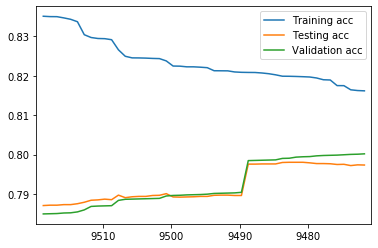

In [77]:
fig, ax = plt.subplots()
ax.set_xlim(lx[0]+1, lx[len(lx)-1]-1)
plt.plot(lx, l_train, label='Training acc')
plt.plot(lx, l_test, label='Testing acc')
plt.plot(lx, l_val, label = 'Validation acc')
plt.legend(loc = 'upper right')
plt.savefig('pruning.png')

# Report
There are improvements across pruning stages but test and valid accuracy could be increased more than it did. The setbacks in my program were that the decision tree implementation were using much higher time to build a full tree (57.04122321 minutes). Thus, I had to set my min_sample_split = 10. Would it be less than 10 (perhaps default=2), the improvement in accuracy would have been much higher.
The problem statement dictates to post-prune the tree. On the contrary if I was pruning at the time of tree construction, it would save alot of time.

Best Accuracy before pruning: 0.783
Best Accuracy after pruning: 0.8001